<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 7: Ensembles and Stacking</h2>
<br>

<a href="#Data:-Twitter-Airline-Sentiment">Twitter Airline Sentiment Data</a> <br>
<a href="#Data Preparation">Data Preparation</a> <br>
<a href="#Text-Classification-Algorithms">Text Classification Models</a> <br>
<a href="#Voting-Classifier">Voting Classifier</a> <br>
<a href="#Model-Stacking">Model Stacking</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import nltk
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, log_loss

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import  RandomForestClassifier
import lightgbm as lgb

##Twitter Airline Sentiment Data

In this lesson we revisit the Twitter airline sentiment dataset. To save time, we directly load the processed dataset that we constructed in the earlier lesson. 

In [4]:
data = pd.read_pickle('Datasets/processed_tweets.pickle')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tokens,positive
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, it', realli, aggress, blast, ...",0
4,570300817074462722,negative,1.0,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, it', realli, big, bad, thing]",0
5,570300767074181121,negative,1.0,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, serious, would, pay, 30, flig...",0
9,570295459631263746,positive,1.0,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),"[@virginamerica, amaz, arriv, hour, earli, you...",1
11,570289724453216256,positive,1.0,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York,"[@virginamerica, <3, pretti, graphic, much, be...",1


In [5]:
data[['text','tokens']].tail(10)

,text,tokens
14625,@AmericanAir Flight 236 was great. Fantastic c...,"[@americanair, flight, 236, great, fantast, ca..."
14626,@AmericanAir Flight 953 NYC-Buenos Aires has b...,"[@americanair, flight, 953, nyc-bueno, air, de..."
14627,"@AmericanAir Flight Cancelled Flightled, can't...","[@americanair, flight, cancel, flightl, can't,..."
14628,Thank you. “@AmericanAir: @jlhalldc Customer R...,"[thank, “, @americanair, @jlhalldc, custom, re..."
14629,@AmericanAir How do I change my flight if the ...,"[@americanair, chang, flight, phone, system, k..."
14630,@AmericanAir Thanks! He is.,"[@americanair, thank]"
14631,@AmericanAir thx for nothing on getting us out...,"[@americanair, thx, noth, get, us, countri, ba..."
14633,@AmericanAir my flight was Cancelled Flightled...,"[@americanair, flight, cancel, flightl, leav, ..."
14636,@AmericanAir leaving over 20 minutes Late Flig...,"[@americanair, leav, 20, minut, late, flight, ..."
14638,"@AmericanAir you have my money, you change my ...","[@americanair, money, chang, flight, don't, an..."


In [6]:
# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = train['positive'].values
y_test = test['positive'].values

##Data preparation

Compute frequency distribution of tokens.

In [7]:
fdist = nltk.FreqDist()
for words in train['tokens']:
    for word in words:
            fdist[word] += 1

Discard features with too few appearances, retrieve list of remaining tokens.

In [8]:
features = pd.Series(dict(fdist))
features = features.sort_values(ascending=False)
features = features[features>=5]
len(features)

1551

Rank features based on univariate performance, if we want to include screening.  

In [9]:
def univariate_design_matrix(feature, series):
    X=series.apply(lambda tokens: (feature in tokens))
    X= X.astype(int) 
    return X.values.reshape((-1,1)) # converting to a NumPy matrix, as requiresd

def training_error(feature):
    X_train = univariate_design_matrix(feature, train['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    prob = nbc.predict_proba(X_train)
    return log_loss(y_train, prob)

losses=[]
for feature in features.index:
    losses.append(training_error(feature))

ranked = pd.Series(losses, index=features.index)
ranked = ranked.sort_values()
ranked_features = list(ranked.index)

Build design matrix (slow to run).

In [10]:
from scipy.sparse import lil_matrix

def design_matrix(features, series):
    X = lil_matrix((len(series),len(features))) # initialise 
    for i in range(len(series)): 
        tokens = series.iloc[i]
        for j, feature in enumerate(features): # scan the list of features
            if feature in tokens: # if the feature is among the tokens, 
                X[i, j]= 1.0
    return X

X_train = design_matrix(ranked_features, train['tokens'])
X_test = design_matrix(ranked_features, test['tokens'])

## Text Classification Models

### Naive Bayes

In [11]:
nbc= BernoulliNB()
nbc.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

###  Regularised Logistic Regression

In [12]:
logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='neg_log_loss', solver='liblinear',
           tol=0.0001, verbose=0)

In [13]:
np.sum(np.abs(logit_l1.coef_) == 0.0)

1093

In [14]:
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

### Random Forest

In [15]:
%%time

model = RandomForestClassifier(criterion = 'entropy',  n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': np.arange(50, X_train.shape[1], 50),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, scoring='neg_log_loss',
                               return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 250} 

Wall time: 2min 6s


### Gradient Boosting

In [16]:
%%time 

from xgboost import XGBClassifier

model = XGBClassifier()

alphas = [0] + list(np.logspace(-10, 10, 81, base=2))

tuning_parameters = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000],
    'max_depth' : [1, 2, 3, 4],
    'reg_alpha': alphas,
}


gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5,  scoring='neg_log_loss',
                               return_train_score=False, n_jobs=4, random_state = 10)
gb_search.fit(X_train, y_train)

gb = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'reg_alpha': 0.0011613350732448448, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.1} 

Wall time: 8min 5s


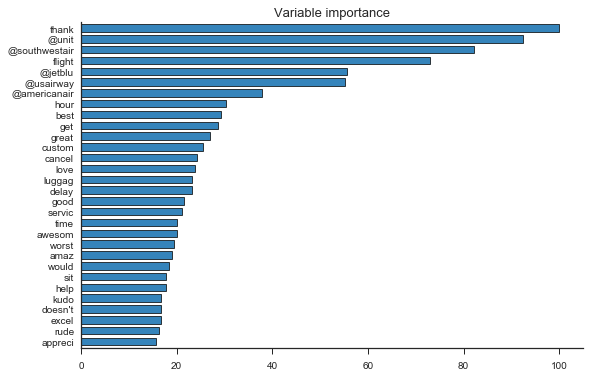

In [25]:
from statlearning import plot_feature_importance
plot_feature_importance(gb, ranked_features, max_features=30)
plt.show()

### Linear Support Vector Machine

In [21]:
%%time

from sklearn.svm import LinearSVC

Cs = np.logspace(-10, 10, 81, base=2)

model = LinearSVC(loss='hinge')

tuning_parameters ={
    'C': Cs,
}

svm_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
svm_search.fit(X_train, y_train)

svm = svm_search.best_estimator_

print('Best parameters found by grid search:', svm_search.best_params_, '\n')

Best parameters found by grid search: {'C': 0.25} 

Wall time: 10.1 s


## Voting Classifier

In [22]:
%%time
from sklearn.ensemble import VotingClassifier

clfs = [('clf1', nbc), ('clf2',  logit_l1), ('clf3',  logit_l2),  ('clf4',  gb), ('clf5',  svm) ]

vhard = VotingClassifier(clfs)
vhard.fit(X_train, y_train)

Wall time: 14 s


In [23]:
%%time
clfs = [('clf1', nbc), ('clf2', logit_l1), ('clf3',  logit_l2), ('clf4',  gb)]
# We exclude SVM since it does not esimate probabilities

vsoft = VotingClassifier(clfs, voting='soft')
vsoft.fit(X_train, y_train)

Wall time: 13.6 s


## Model Stacking

The stacking classifier from mlxtend is not compatible with XGBoost in our setting, so that we unfortunately have to exclude boosting from the stacking ensemble. 

In [25]:
%%time 
from mlxtend.classifier import StackingCVClassifier

stack = StackingCVClassifier([nbc, logit_l1, logit_l2], use_probas=True, meta_classifier = LogisticRegression(C=1e4),
                             store_train_meta_features=True)
stack.fit(X_train.todense(), y_train.ravel())

Wall time: 1min 45s


## Model Evaluation


In [26]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Naive Bayes', 'Logistic L1', 'Logistic L2', 'Random Forest', 
      'Boosting', 'Linear SVM', 'Hard Voting', 'Soft Voting', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[nbc, logit_l1, logit_l2, rf, gb, svm, vhard, vsoft, stack]

y_prob = np.zeros((len(test), len(rows)))

for i, method in enumerate(methods):
    
    if i < 8:
        y_pred = method.predict(X_test)
    else:
        y_pred = method.predict(X_test.todense())
    
   
    try:  # this try block is necessary because hard voting and SVM are not compatible with probability predictions
        if i < 8:
            y_prob[:, i] = method.predict_proba(X_test)[:,1]
            results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])
        else: 
            y_prob[:, i] = method.predict_proba(X_test.todense())[:,1]
            results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])
    except:
        pass

    confusion  = confusion_matrix(y_test, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Naive Bayes,0.055,0.851,0.965,0.979,0.837
Logistic L1,0.054,0.808,0.975,0.978,0.872
Logistic L2,0.052,0.793,0.980,0.981,0.893
Random Forest,0.082,0.694,0.966,0.939,0.809
Boosting,0.050,0.802,0.981,0.978,0.899
Linear SVM,0.051,0.804,0.980,0.000,0.894
Hard Voting,0.048,0.817,0.980,0.000,0.896
Soft Voting,0.046,0.830,0.981,0.983,0.900
Stack,0.046,0.834,0.979,0.983,0.894
